加了 subject 信息，表现比不加要好，到了 0.834分

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../src")

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from Dataset import Dataset
import tensorflow as tf
import typing
from tensorflow import keras as k

if typing.TYPE_CHECKING:
    print("emmm")
    from keras.api._v2 import keras as k

import os

os.environ["http_proxy"] = "http://localhost:6152"
os.environ["https_proxy"] = "http://localhost:6152"
os.environ["NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE"] = "TRUE"

In [2]:
run = neptune.init(
    project="h3z/Tabular-Playground-Series-Apr-2022",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MDI4ZDMyYy1mODYwLTRhMzUtOWNlZC0xODBkZDIyZDkwN2QifQ==",
)  # your credentials

https://app.neptune.ai/h3z/Tabular-Playground-Series-Apr-2022/e/TAB-7
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
params = {"lr": 0.001, "epochs": 100, "batch_size": 128}
run["parameters"] = params

In [4]:
ds = Dataset()
sensor_cols = [f"sensor{i:02d}" for i in range(13)]

In [5]:
ds.train.query("sequence == 0").head()

,sequence,subject,step,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [51]:
def lstm_model(timesteps, feature):

    input1 = k.layers.Input(shape=(timesteps, feature))
    x1 = k.layers.LSTM(32)(input1)
    x1 = k.layers.Dense(16)(x1)

    input2 = k.layers.Input(shape=(1))
    x2 = k.layers.Embedding(1, 16)(input2)
    # x2 = k.layers.Reshape((-1, 16))(x2)
    x2 = tf.squeeze(x2, axis=1)

    x = k.layers.Concatenate(axis=-1)([x1, x2])
    x = k.layers.Dense(16)(x)
    output = k.layers.Dense(1, activation="sigmoid")(x)

    model = k.Model(inputs=[input1, input2], outputs=output)
    return model
    # model = k.models.Sequential()
    # model.add(k.layers.Input(shape=(timesteps, feature)))
    # model.add(k.layers.LSTM(32))
    # model.add(k.layers.Dense(1, activation="sigmoid"))
    # return model


# timesteps = ds.train.sequence.value_counts()[0]
# feature = len(sensor_cols)
# model = lstm_model(timesteps, feature)

# k.utils.plot_model(model, show_shapes=True)

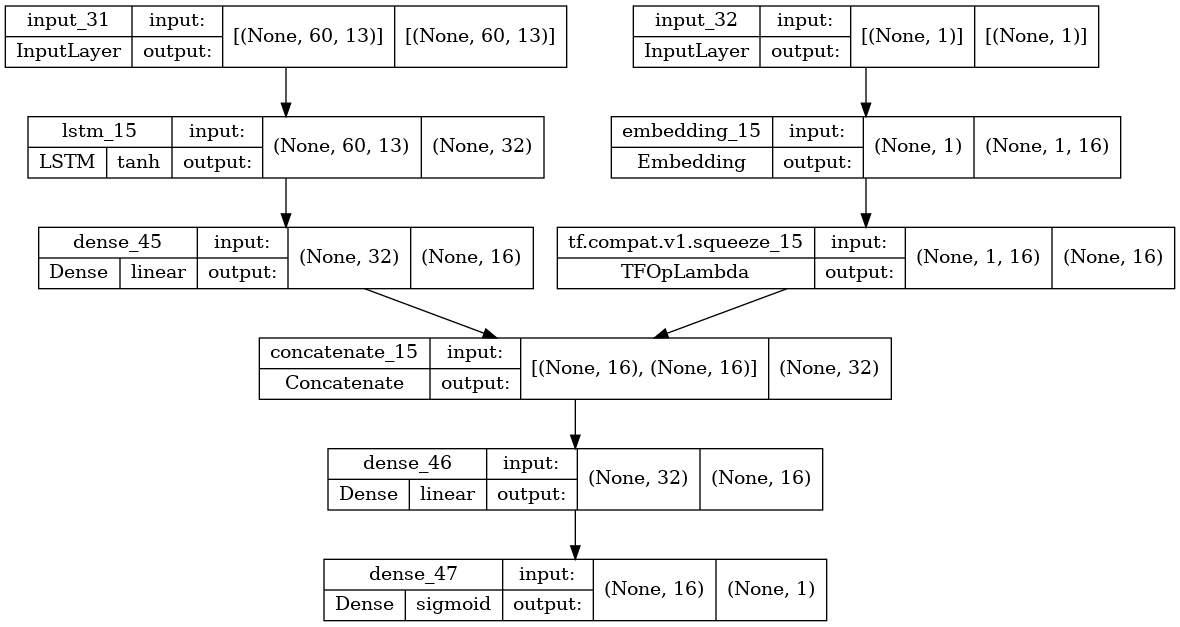

In [60]:
timesteps = ds.train.sequence.value_counts()[0]
feature = len(sensor_cols)
model = lstm_model(timesteps, feature)

X = ds.train[sensor_cols].values.reshape(-1, timesteps, 13)
X_subject = ds.train.groupby("sequence").subject.first().values.reshape(-1, 1)
y = ds.label.state.values.reshape(-1, 1)

# X_dataset = tf.data.Dataset.from_tensor_slices((X))
# X_subject_dataset = tf.data.Dataset.from_tensor_slices((X_subject))
# y_dataset = tf.data.Dataset.from_tensor_slices((y))

# xy = (
#     tf.data.Dataset.zip(
#         (tf.data.Dataset.zip((X_dataset, X_subject_dataset)), y_dataset)
#     )
#     .batch(params["batch_size"])
#     .shuffle(params["batch_size"] * 4)
# )


xy = (
    tf.data.Dataset.from_tensor_slices(((X, X_subject), y))
    # tf.data.Dataset.from_tensor_slices((X, y))
    .batch(params["batch_size"]).shuffle(params["batch_size"] * 4)
)

L = int(len(xy) * 0.8)

model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy()],
)

k.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [61]:
neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

history = model.fit(
    # [X, X_subject],
    # y,
    xy.take(L),
    validation_data=xy.skip(L),
    epochs=params["epochs"],
    callbacks=[neptune_cbk],
)

Epoch 1/100
162/162 [==============================] - 4s 12ms/step - loss: 0.6832 - binary_accuracy: 0.5633 - val_loss: 0.6709 - val_binary_accuracy: 0.5806
Epoch 2/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6589 - binary_accuracy: 0.6032 - val_loss: 0.6396 - val_binary_accuracy: 0.6334
Epoch 3/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6378 - binary_accuracy: 0.6265 - val_loss: 0.6352 - val_binary_accuracy: 0.6321
Epoch 4/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6203 - binary_accuracy: 0.6462 - val_loss: 0.6196 - val_binary_accuracy: 0.6454
Epoch 5/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6053 - binary_accuracy: 0.6582 - val_loss: 0.5941 - val_binary_accuracy: 0.6652
Epoch 6/100
162/162 [==============================] - 2s 10ms/step - loss: 0.5827 - binary_accuracy: 0.6776 - val_loss: 0.5624 - val_binary_accuracy: 0.7070
Epoch 7/100
162/162 [==============================]

In [62]:
for metric in history.history.keys():
    run[f"eval/{metric}"] = history.history[metric][-1]

run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.


All 5 operations synced, thanks for waiting!


In [64]:
preds = model.predict(
    (
        ds.test[sensor_cols].values.reshape(-1, timesteps, 13),
        ds.test.groupby("sequence").subject.first().values.reshape(-1, 1),
    )
)
ds.submit_result(preds)